In [1]:
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

Time to combine everything you have learned so far for image segmentation. Let's segment our coins image using two approaches.

## 1. Region based segmentation

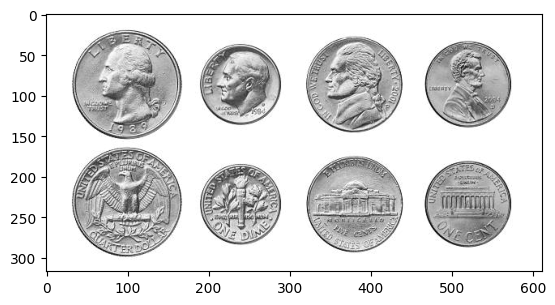

In [77]:
im = cv2.imread('images/coins.jpeg', 0)
plt.imshow(im, cmap='gray')

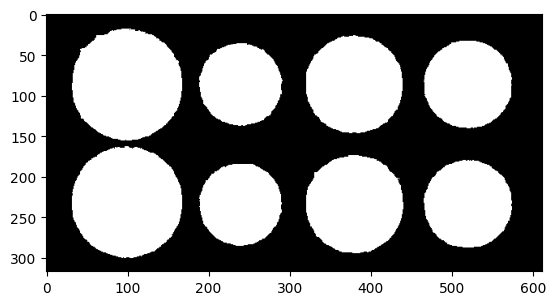

In [2]:
im = cv2.imread('images/coins.jpeg', 0)
im = cv2.medianBlur(im, 5)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV)
plt.imshow(output_im, cmap='gray')

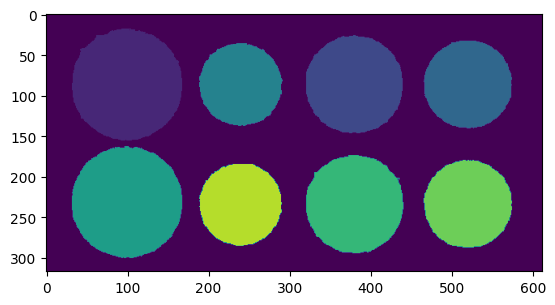

In [3]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
plt.imshow(labels)

Let's look at the stats:

In [4]:
# x, y, w, h, area
stats

array([[     0,      0,    612,    317, 106943],
       [    32,     18,    136,    138,  14754],
       [   321,     26,    119,    121,  11392],
       [   466,     33,    109,    108,   9249],
       [   189,     36,    103,    102,   8116],
       [    32,    163,    136,    138,  14727],
       [   321,    174,    120,    121,  11468],
       [   466,    180,    109,    108,   9241],
       [   189,    185,    102,    101,   8112],
       [   435,    202,      1,      2,      2]], dtype=int32)

First row is the background, the 8 rows that follow belong to each coin. How about the final row?

`[435, 202, 1, 2, 2]`

It is a 2 pixel object. It is so small that we cannot see it, but we can zoom in.

In [5]:
x, y = centroids[-1]
x = int(x)
y = int(y)
print(f'The center of the object is {x, y}')

The center of the object is (435, 202)


So let's display 40 x 40 region centered around (435, 202)

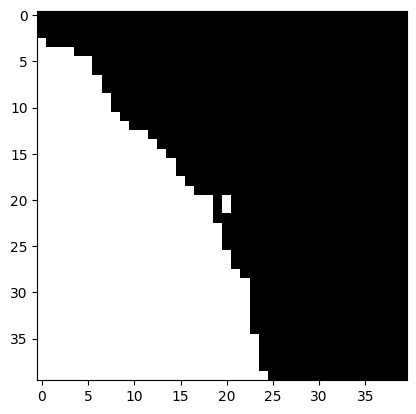

In [6]:
plt.imshow(output_im[y-20:y+20, x-20:x+20], cmap='gray')

It seems these 2 pixels slipped through the blurring operation. We can do the following:

1. Filter connected components using the area from the stats array.

or we can do the following before calling connected components:

2. Erosion + Dilation
3. Use more blurring.
4. Change the threshold.

The optimal approach depends on the application. When processing images, you will encounter such situations frequently. You need to be able to figure out possible ways to deal with it, try a few and decide which one is optimal for your use case.

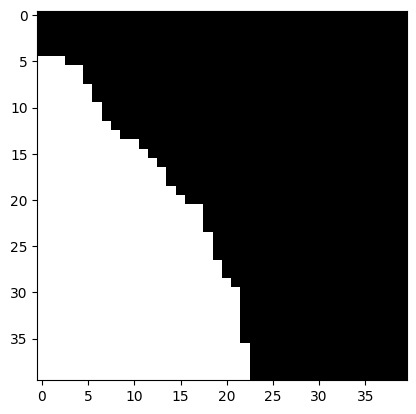

In [7]:
# Let's do a quick try to see if we can get rid of it with erosion
kernel = np.ones((3, 3), np.uint8)
trial_output = cv2.erode(output_im, kernel, iterations=1)
plt.imshow(trial_output[y-20:y+20, x-20:x+20], cmap='gray')

It worked! Next step is to use dilation so that we keep the original coin size. Let's put all this together:

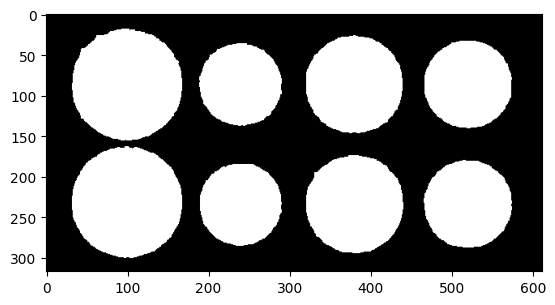

In [8]:
im = cv2.imread('images/coins.jpeg', 0)
im = cv2.medianBlur(im, 5)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((3, 3), np.uint8)
output_im = cv2.erode(output_im, kernel, iterations=1)
output_im = cv2.dilate(output_im, kernel, iterations=1)
plt.imshow(output_im, cmap='gray')

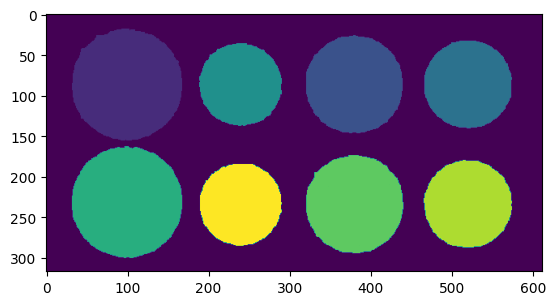

In [9]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
plt.imshow(labels)

In [10]:
stats

array([[     0,      0,    612,    317, 106991],
       [    32,     18,    136,    138,  14744],
       [   321,     26,    119,    121,  11389],
       [   467,     33,    108,    108,   9243],
       [   189,     36,    102,    102,   8111],
       [    32,    163,    136,    138,  14717],
       [   321,    174,    120,    121,  11466],
       [   466,    180,    109,    108,   9236],
       [   190,    185,    101,    101,   8107]], dtype=int32)

now we have 9 components as expected: background + 8 coins. You can also draw bounding boxes on the original image.

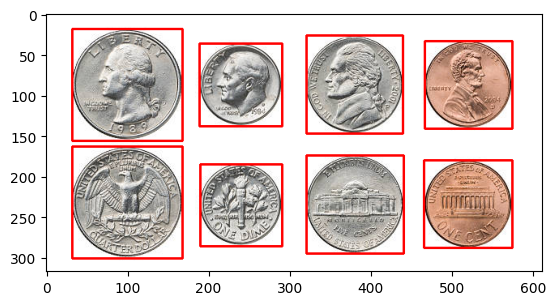

In [11]:
im = cv2.imread('images/coins.jpeg')
for i in range(1, len(stats)):
    x, y, w, h, _ = stats[i]
    im = cv2.rectangle(im, (x, y), (x+w, y+h), (0, 0, 255), 2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

### An alternative

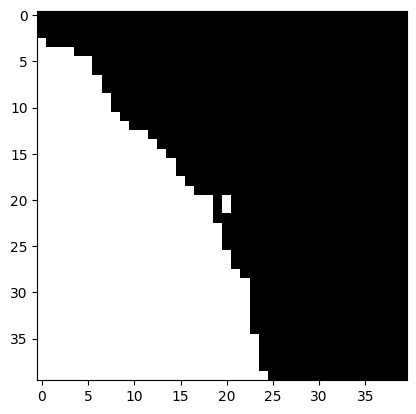

In [12]:
im = cv2.imread('images/coins.jpeg', 0)
im = cv2.medianBlur(im, 5)
th, output_im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)
x, y = centroids[-1]
x = int(x)
y = int(y)
plt.imshow(output_im[y-20:y+20, x-20:x+20], cmap='gray')

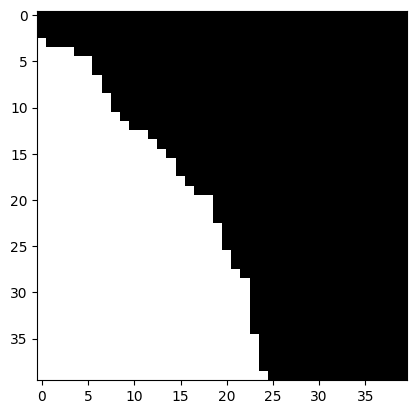

In [13]:
# skimage has a function called remove_small_objects
alternative = skimage.morphology.remove_small_objects(labels)
plt.imshow(alternative[y-20:y+20, x-20:x+20], cmap='gray')

## 2. Edge based segmentation

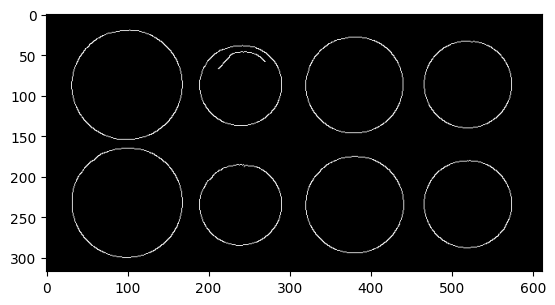

In [14]:
im = cv2.imread('images/coins.jpeg', 0)
im = cv2.GaussianBlur(im, (13, 13), 0)
edges = cv2.Canny(im, threshold1=100, threshold2=240)
plt.imshow(edges, cmap='gray')

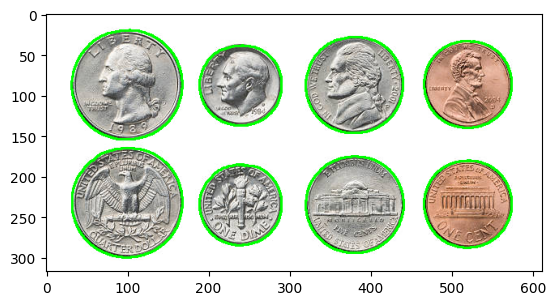

In [15]:
contours, hierarchy = cv2.findContours(edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
im = cv2.imread('images/coins.jpeg')
im = cv2.drawContours(im, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

**Exercise 5.1**

scikit-image has a coins image as well. Find the coins. Expected output:

<img src='images/coins_skimage_exercise.png'>

Hint: https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html read this again if needed.

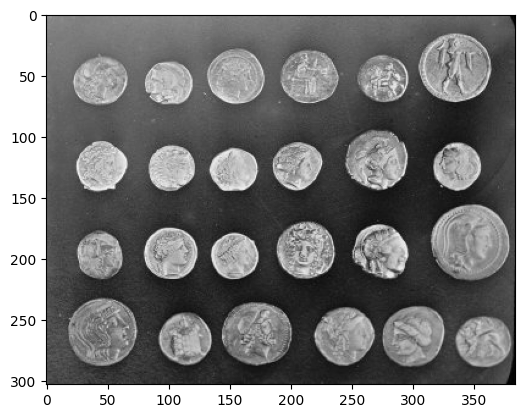

In [146]:
im_coins = skimage.data.coins()
plt.imshow(im_coins, cmap='gray')

In [151]:
im_coins = cv2.medianBlur(im_coins, 15)

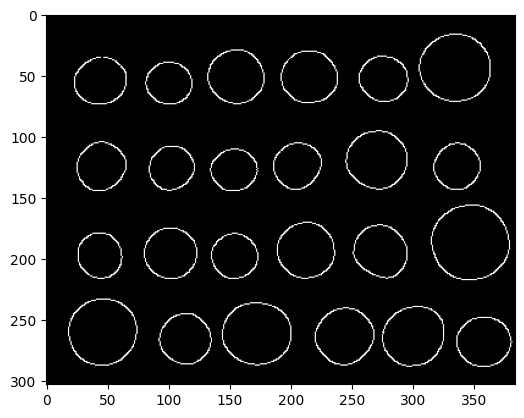

In [172]:
edges = cv2.Canny(im_coins, threshold1=120, threshold2=350)
plt.imshow(edges, cmap='gray')

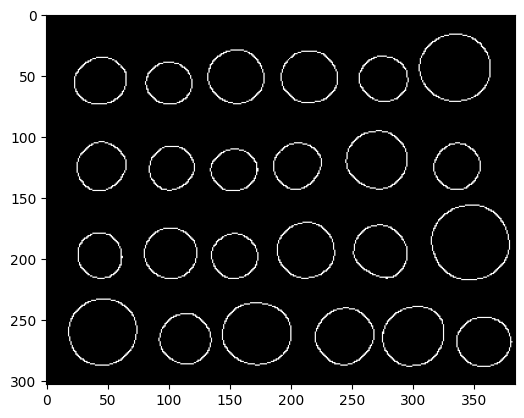

In [174]:
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
closed_edges = cv2.erode(dilated, kernel, iterations=1)
plt.imshow(closed_edges, cmap='gray')

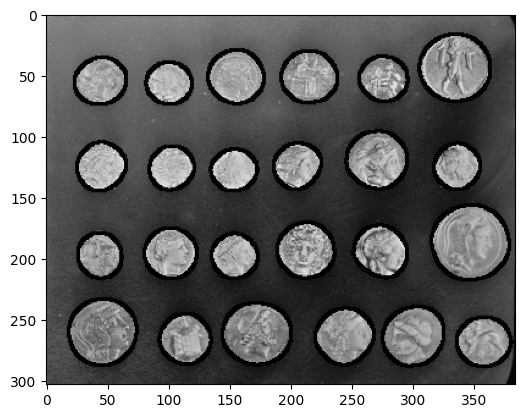

In [176]:
contours, hierarchy = cv2.findContours(closed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im = skimage.data.coins()
im = cv2.drawContours(im, contours, contourIdx=-1, color=(0, 255, 0), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im, cmap='gray')

## 3. Moving forward

You have learned a lot this week congrats! We will move on towards deep learning in the upcoming weeks. However, note that the traditional methods covered here are not exhaustive. Take a look at the following to be familiar with the additional methods that are not covered here but useful:

https://scikit-image.org/docs/stable/auto_examples/segmentation/index.html

https://scikit-image.org/docs/stable/auto_examples/features_detection/index.html

https://scikit-image.org/docs/stable/auto_examples/applications/index.html

https://docs.opencv.org/4.x/d1/dc5/tutorial_background_subtraction.html

